In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/rev.dr.sylviablessings/mufasa_project/data_collection/character_dialogue.csv")
data.head()

,Character,Dialogue
0,Mufasa,The Lion King
1,Mufasa,The Lion King
2,Lebo,M ♪ 'Xesha lifikile wemampondo. Awu 'xesha ...
3,Lebo,M ♪ 'Xesha lifikile wemampondo. Awu 'xesha ...
4,Cut,to a herd of giraffes. They begin to walk acro...


In [3]:
data.shape

(6249, 2)

In [5]:
## Drop Duplicates
data.drop_duplicates(inplace=True)

In [6]:
data.shape

(2615, 2)

#### Clean Dialogue Text

In [5]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rev.dr.sylviablessings/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rev.dr.sylviablessings/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def clean_dialogue(text):
    # Tokenize the text
    words = word_tokenize(text.lower())

    # Remove punctuation and stopwords
    cleaned = [
        word for word in words
        if word not in string.punctuation and word not in stopwords.words('english')
    ]

    return ' '.join(cleaned)

In [7]:
import re

def clean_text(text):
    # Remove single quotes and symbols like ♪ and other non-alphanumeric characters except spaces
    cleaned = re.sub(r"[^\w\s]", "", text)
    return cleaned

# Example usage
dialogue = "♪ 'xesha lifikile wemampondo awu 'xesha lifiki..."
cleaned_dialogue = clean_text(dialogue)
print(cleaned_dialogue)

 xesha lifikile wemampondo awu xesha lifiki


In [8]:
# make dialogue lower case
data['Dialogue'] = data['Dialogue'].apply(clean_text)

In [9]:
data.head()

,Character,Dialogue
0,Mufasa,The Lion King
1,Mufasa,The Lion King
2,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...
3,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...
4,Cut,to a herd of giraffes They begin to walk acros...


In [10]:
data.shape

(6249, 2)

#### Create Word Cloud

In [11]:
from wordcloud import WordCloud

In [15]:
filtered_data = data[data['Character'].isin(['Mufasa', 'Taka'])].copy()

In [16]:
character_texts = filtered_data.groupby('Character')['Dialogue'].apply(lambda x: ' '.join(x)).to_dict()

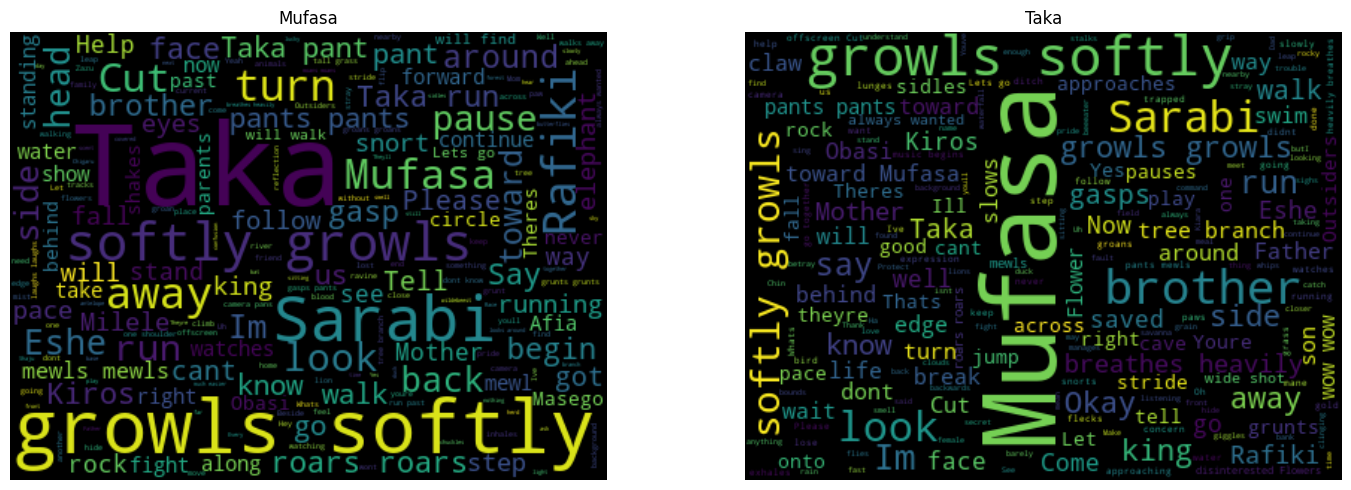

In [17]:
plt.figure(figsize=(15, 5))

for i, (character, text) in enumerate(character_texts.items(), 1):
    plt.subplot(1, len(character_texts), i)
    wc = WordCloud(width=400, height=300, background_color='black').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(character)
    plt.axis("off")

plt.tight_layout()
plt.show()

#### VADER for Sentiment Analyzer

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [20]:
def vader_sentiment(text):
    return (
    'positive' if analyzer.polarity_scores(text)['compound'] >= 0.05
    else 'negative' if analyzer.polarity_scores(text)['compound'] <= -0.05
    else 'neutral'
)

In [21]:
data['Predicted_sentiment'] = data['Dialogue'].apply(vader_sentiment)

In [22]:
data.head()

,Character,Dialogue,Predicted_sentiment
0,Mufasa,The Lion King,neutral
1,Mufasa,The Lion King,neutral
2,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...,neutral
3,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...,neutral
4,Cut,to a herd of giraffes They begin to walk acros...,positive


In [23]:
data['Predicted_sentiment'].value_counts()

Predicted_sentiment
neutral     4317
positive    1064
negative     868
Name: count, dtype: int64

In [24]:
# Combine character and dialogue into one text field
data['Combined_text'] = data.apply(lambda x: f"{x['Character']}: {x['Dialogue']}", axis=1)

In [25]:
data.head()

,Character,Dialogue,Predicted_sentiment,Combined_text
0,Mufasa,The Lion King,neutral,Mufasa: The Lion King
1,Mufasa,The Lion King,neutral,Mufasa: The Lion King
2,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...,neutral,Lebo: M Xesha lifikile wemampondo Awu xesh...
3,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...,neutral,Lebo: M Xesha lifikile wemampondo Awu xesh...
4,Cut,to a herd of giraffes They begin to walk acros...,positive,Cut: to a herd of giraffes They begin to walk ...


#### Label Encode Sentiments

In [27]:
label_map = {'negative':0, 'neutral': 1, 'positive':2}
data['label'] = data['Predicted_sentiment'].map(label_map)

In [28]:
data.head()

,Character,Dialogue,Predicted_sentiment,Combined_text,label
0,Mufasa,The Lion King,neutral,Mufasa: The Lion King,1
1,Mufasa,The Lion King,neutral,Mufasa: The Lion King,1
2,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...,neutral,Lebo: M Xesha lifikile wemampondo Awu xesh...,1
3,Lebo,M Xesha lifikile wemampondo Awu xesha lifi...,neutral,Lebo: M Xesha lifikile wemampondo Awu xesh...,1
4,Cut,to a herd of giraffes They begin to walk acros...,positive,Cut: to a herd of giraffes They begin to walk ...,2


#### Train - Validation Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
            data['Combined_text'].tolist(), data['label'].tolist(), test_size=0.2, random_state=32)

#### Oversample Training Set

In [31]:
from imblearn.over_sampling import RandomOverSampler

In [32]:
ros = RandomOverSampler(random_state=32)
X_resampled, y_resampled = ros.fit_resample(np.array(train_texts).reshape(-1,1), train_labels)
resampled_texts = [x[0] for x in X_resampled]

#### Tokenize the Text

In [33]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

In [37]:
train_encodings = tokenizer(resampled_texts, truncation=True, padding=True, return_tensors="tf")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="tf")

In [35]:
import tensorflow as tf

2025-05-06 20:45:08.926158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
def convert_to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))


train_dataset = convert_to_tf_dataset(dict(train_encodings), y_resampled).shuffle(1000).batch(16)
val_dataset = convert_to_tf_dataset(val_encodings, val_labels).batch(16)

#### Load and Compile TinyBERT Model

In [41]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=3,
    from_pt=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.0.bias', 'fit_denses.0.weight', 'fit_denses.4.bias', 'fit_denses.4.weight', 'fit_denses.1.bias', 'fit_denses.1.weight', 'fit_denses.2.bias', 'fit_denses.3.weight', 'fit_denses.2.weight', 'fit_denses.3.bias']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classif

In [54]:
# Only needed once in your code
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [53]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#### Train Model

In [55]:
model.fit(train_dataset, validation_data=val_dataset, epochs=4)

Epoch 1/4
649/649 [==============================] - 1226s 2s/step - loss: 0.3034 - accuracy: 0.9023 - val_loss: 2.1140 - val_accuracy: 0.2904
Epoch 2/4
649/649 [==============================] - 1189s 2s/step - loss: 0.1092 - accuracy: 0.9661 - val_loss: 0.8572 - val_accuracy: 0.7144
Epoch 3/4
649/649 [==============================] - 1195s 2s/step - loss: 0.0544 - accuracy: 0.9839 - val_loss: 0.2960 - val_accuracy: 0.9104
Epoch 4/4
649/649 [==============================] - 1198s 2s/step - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.1982 - val_accuracy: 0.9496


In [56]:
model.evaluate(val_dataset)
model.save_pretrained("character_sentiment_model")
tokenizer.save_pretrained("character_sentiment_model")

79/79 [==============================] - 43s 547ms/step - loss: 0.1982 - accuracy: 0.9496


('character_sentiment_model/tokenizer_config.json',
 'character_sentiment_model/special_tokens_map.json',
 'character_sentiment_model/vocab.txt',
 'character_sentiment_model/added_tokens.json',
 'character_sentiment_model/tokenizer.json')

In [57]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model = TFAutoModelForSequenceClassification.from_pretrained('/Users/rev.dr.sylviablessings/mufasa_project/mufasa_sentiment_project/sentiment_app/character_sentiment_model')
tokenizer = AutoTokenizer.from_pretrained('/Users/rev.dr.sylviablessings/mufasa_project/mufasa_sentiment_project/sentiment_app/character_sentiment_model')

Some layers from the model checkpoint at /Users/rev.dr.sylviablessings/mufasa_project/mufasa_sentiment_project/sentiment_app/character_sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_13']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /Users/rev.dr.sylviablessings/mufasa_project/mufasa_sentiment_project/sentiment_app/character_sentiment_model.
If your task is similar to the task the model of the checkpoint w

In [58]:
import numpy as np

def sentiment_prediction(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = model(inputs)
    logits = outputs.logits.numpy()[0]
    probs = tf.nn.softmax(logits).numpy()
    sentiment_class = np.argmax(probs)
    sentiment_score = probs[sentiment_class]  # confidence
    return sentiment_class, float(sentiment_score)

In [62]:
emotion_keywords = {
    "wisdom": ["understand", "know", "truth", "life"],
    "love": ["love", "care", "heart", "family", "affection", "fond", "tenderness"],
    "serenity": ["peace", "calm", "still", "safe"],
     "joy": ["happy", "joy", "delight", "glee", "cheerful"],
    "trust": ["trust", "respect", "admiration"],
    "anger": ["angry", "rage", "annoyed", "furious"],
    "fear": ["afraid", "scared", "nervous", "terrified"],
    "sadness": ["sad", "grief", "lonely", "depressed"],
    "disgust": ["disgusted", "gross", "repulsed", "nauseated"],
    "surprise": ["surprised", "shocked", "amazed"],
    "anticipation": ["anticipate", "eager", "hopeful"]
}

def extract_emotions(text):
    emotions = []
    words = text.lower().split()
    for emotion, keywords in emotion_keywords.items():
        if any(word in words for word in keywords):
            emotions.append(emotion)
    return emotions

In [63]:
from collections import defaultdict, Counter

character_stats = defaultdict(lambda: {
    "total_lines": 0,
    "positive_lines": 0,
    "neutral_lines": 0,
    "negative_lines": 0,
    "sentiment_scores": [],
    "emotions": []
})

for _, row in data.iterrows():
    character = row['Character']
    text = row['Dialogue']

    sentiment_class, sentiment_score = sentiment_prediction(text)
    emotions = extract_emotions(text)

    character_stats[character]["total_lines"] += 1
    character_stats[character]["sentiment_scores"].append(sentiment_score)
    character_stats[character]["emotions"].extend(emotions)

    if sentiment_class == 0:
        character_stats[character]["negative_lines"] += 1
    elif sentiment_class == 1:
        character_stats[character]["neutral_lines"] += 1
    else:
        character_stats[character]["positive_lines"] += 1

final_output = {}

for character, stats in character_stats.items():
    avg_score = round(np.mean(stats["sentiment_scores"]), 2)
    top_emotions = [e for e, _ in Counter(stats["emotions"]).most_common(3)]
    
    final_output[character] = {
        "total_lines": stats["total_lines"],
        "avg_sentiment_score": avg_score,
        "positive_lines": stats["positive_lines"],
        "neutral_lines": stats["neutral_lines"],
        "negative_lines": stats["negative_lines"],
        "top_emotions": top_emotions
    }


In [64]:
import json

with open('character_sentiment_summary.json', 'w') as f:
    json.dump(final_output, f, indent=2)
